In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Imports

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import cv2
import os
from zipfile import ZipFile
import time
from datetime import datetime
import itertools

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Conv2D, AveragePooling2D, GlobalAveragePooling2D
from tensorflow.keras import utils
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint

# Setting random seeds to reduce the amount of randomness in the neural net weights and results
# The results may still not be exactly reproducible

np.random.seed(42)
tf.random.set_seed(42)

In [3]:
# Unzipping the dataset file combined_faces.zip

combined_faces_zip_path = "/content/drive/MyDrive/GraduationCapston/Foreigner_age_predict/age/1.1_age_input_output/input/combined_faces.zip"
extracted_path='/content/combined_faces'
with ZipFile(combined_faces_zip_path, 'r') as myzip:
    myzip.extractall(extracted_path)
    print('Done unzipping combined_faces.zip')

Done unzipping combined_faces.zip


In [4]:
# Unzipping the dataset file combined_faces.zip

combined_faces_zip_path = "/content/drive/MyDrive/GraduationCapston/Foreigner_age_predict/age/combined_faces_train_augmented-002.zip"
extracted_path='/content/combined_faces'
with ZipFile(combined_faces_zip_path, 'r') as myzip:
    myzip.extractall(extracted_path)
    print('Done unzipping combined_faces_train_augmented.zip')

Done unzipping combined_faces_train_augmented.zip


In [5]:
# Importing the augmented training dataset and testing dataset to create tensors of images using the filename paths.

train_aug_df = pd.read_csv("/content/drive/MyDrive/GraduationCapston/Foreigner_age_predict/age/1.1_age_input_output/input/images_filenames_labels_train_augmented_1.csv")
test_df = pd.read_csv("/content/drive/MyDrive/GraduationCapston/Foreigner_age_predict/age/1.1_age_input_output/input/images_filenames_labels_test_1.csv")

In [6]:
# Defining a function to return the class labels corresponding to the re-distributed 7 age-ranges.

def class_labels_reassign(age):

    if 1 <= age <= 2:
        return 0
    elif 3 <= age <= 9:
        return 1
    elif 10 <= age <= 20:
        return 2
    elif 21 <= age <= 27:
        return 3
    elif 28 <= age <= 45:
        return 4
    elif 46 <= age <= 65:
        return 5
    else:
        return 6

In [7]:
train_aug_df['target'] = train_aug_df['age'].map(class_labels_reassign)
test_df['target'] = test_df['age'].map(class_labels_reassign)

In [8]:
# Converting the filenames and target class labels into lists for augmented train and test datasets.

train_aug_filenames_list = list(train_aug_df['filename'])
train_aug_labels_list = list(train_aug_df['target'])

test_filenames_list = list(test_df['filename'])
test_labels_list = list(test_df['target'])

In [9]:
# Creating tensorflow constants of filenames and labels for augmented train and test datasets from the lists defined above.

train_aug_filenames_tensor = tf.constant(train_aug_filenames_list)
train_aug_labels_tensor = tf.constant(train_aug_labels_list)

test_filenames_tensor = tf.constant(test_filenames_list)
test_labels_tensor = tf.constant(test_labels_list)

Image Greyscale Function

In [10]:
# Defining a function to read the image, decode the image from given tensor and one-hot encode the image label class.
# Changing the channels para in tf.io.decode_jpeg from 3 to 1 changes the output images from RGB coloured to grayscale.

num_classes = 7

def _parse_function(filename, label):

    image_string = tf.io.read_file(filename)
    image_decoded = tf.io.decode_jpeg(image_string, channels=1)    # channels=1 to convert to grayscale, channels=3 to convert to RGB.
    # image_resized = tf.image.resize(image_decoded, [200, 200])
    label = tf.one_hot(label, num_classes)

    return image_decoded, label

In [11]:
# Getting the dataset ready for the neural network.
# Using the tensor vectors defined above, accessing the images in the dataset and passing them through the function defined above.

train_aug_dataset = tf.data.Dataset.from_tensor_slices((train_aug_filenames_tensor, train_aug_labels_tensor))
train_aug_dataset = train_aug_dataset.map(_parse_function)
# train_aug_dataset = train_aug_dataset.repeat(3)
train_aug_dataset = train_aug_dataset.batch(512)    # Same as batch_size hyperparameter in model.fit() below.

test_dataset = tf.data.Dataset.from_tensor_slices((test_filenames_tensor, test_labels_tensor))
test_dataset = test_dataset.map(_parse_function)
# test_dataset = test_dataset.repeat(3)
test_dataset = test_dataset.batch(512)    # Same as batch_size hyperparameter in model.fit() below.

In [12]:
# Defining a function to read the image, decode the image from given tensor and one-hot encode the image label class.
# Changing the channels para in tf.io.decode_jpeg from 3 to 1 changes the output images from RGB coloured to grayscale.

num_classes = 7

def _parse_function(filename, label):

    image_string = tf.io.read_file(filename)
    image_decoded = tf.io.decode_jpeg(image_string, channels=1)    # channels=1 to convert to grayscale, channels=3 to convert to RGB.
    # image_resized = tf.image.resize(image_decoded, [200, 200])
    label = tf.one_hot(label, num_classes)

    return image_decoded, label

In [13]:
# Getting the dataset ready for the neural network.
# Using the tensor vectors defined above, accessing the images in the dataset and passing them through the function defined above.

train_aug_dataset = tf.data.Dataset.from_tensor_slices((train_aug_filenames_tensor, train_aug_labels_tensor))
train_aug_dataset = train_aug_dataset.map(_parse_function)
# train_aug_dataset = train_aug_dataset.repeat(3)
train_aug_dataset = train_aug_dataset.batch(512)    # Same as batch_size hyperparameter in model.fit() below.

test_dataset = tf.data.Dataset.from_tensor_slices((test_filenames_tensor, test_labels_tensor))
test_dataset = test_dataset.map(_parse_function)
# test_dataset = test_dataset.repeat(3)
test_dataset = test_dataset.batch(512)    # Same as batch_size hyperparameter in model.fit() below.

In [14]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dense

# Define the VGG16-style model
vgg16_model = Sequential()

# Block 1
vgg16_model.add(Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=(200, 200, 1)))
vgg16_model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
vgg16_model.add(MaxPooling2D(pool_size=(2, 2)))

# Block 2
vgg16_model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
vgg16_model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
vgg16_model.add(MaxPooling2D(pool_size=(2, 2)))

# Block 3
vgg16_model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
vgg16_model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
vgg16_model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
vgg16_model.add(MaxPooling2D(pool_size=(2, 2)))

# Global Average Pooling
vgg16_model.add(GlobalAveragePooling2D())

# Fully Connected Layers
vgg16_model.add(Dense(4096, activation='relu'))
vgg16_model.add(Dense(4096, activation='relu'))

# Output Layer
vgg16_model.add(Dense(7, activation='softmax'))

# Print the summary of the VGG16-style model
vgg16_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 200, 200, 64)      640       
                                                                 
 conv2d_1 (Conv2D)           (None, 200, 200, 64)      36928     
                                                                 
 max_pooling2d (MaxPooling2  (None, 100, 100, 64)      0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (None, 100, 100, 128)     73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 100, 100, 128)     147584    
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 50, 50, 128)       0         
 g2D)                                                   

In [15]:
# Import necessary libraries and modules
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint
from tensorflow.keras.optimizers import Adam

# Create callbacks (tensorboard and checkpoint)
tensorboard = TensorBoard(log_dir='logs/')
checkpoint = ModelCheckpoint('best_model.h5', save_best_only=True)

# Compile the VGG16-style model
vgg16_model.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])

# Train the VGG16-style model
vgg16_history = vgg16_model.fit(train_aug_dataset,
                                batch_size=512,
                                validation_data=test_dataset,
                                epochs=30,
                                callbacks=[tensorboard, checkpoint],
                                shuffle=False  # shuffle=False to reduce randomness and increase reproducibility
                               )

Epoch 1/30
458/458 [==============================] - ETA: 0s - loss: 1.8529 - accuracy: 0.3073

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


458/458 [==============================] - 322s 618ms/step - loss: 1.8529 - accuracy: 0.3073 - val_loss: 1.6123 - val_accuracy: 0.3472
Epoch 2/30
458/458 [==============================] - 256s 558ms/step - loss: 1.4053 - accuracy: 0.4278 - val_loss: 1.1891 - val_accuracy: 0.4990
Epoch 3/30
458/458 [==============================] - 256s 559ms/step - loss: 1.1076 - accuracy: 0.5341 - val_loss: 1.0034 - val_accuracy: 0.5759
Epoch 4/30
458/458 [==============================] - 256s 560ms/step - loss: 0.9776 - accuracy: 0.5839 - val_loss: 0.9024 - val_accuracy: 0.6188
Epoch 5/30
458/458 [==============================] - 256s 559ms/step - loss: 0.8944 - accuracy: 0.6176 - val_loss: 0.8408 - val_accuracy: 0.6447
Epoch 6/30
458/458 [==============================] - 255s 557ms/step - loss: 0.8252 - accuracy: 0.6452 - val_loss: 0.8636 - val_accuracy: 0.6370
Epoch 7/30
458/458 [==============================] - 256s 559ms/step - loss: 0.7608 - accuracy: 0.6744 - val_loss: 0.7951 - val_accura

In [16]:
# Checking the train and test loss and accuracy values from the neural network above.

train_loss = vgg16_history.history['loss']
test_loss = vgg16_history.history['val_loss']
train_accuracy = vgg16_history.history['accuracy']
test_accuracy = vgg16_history.history['val_accuracy']

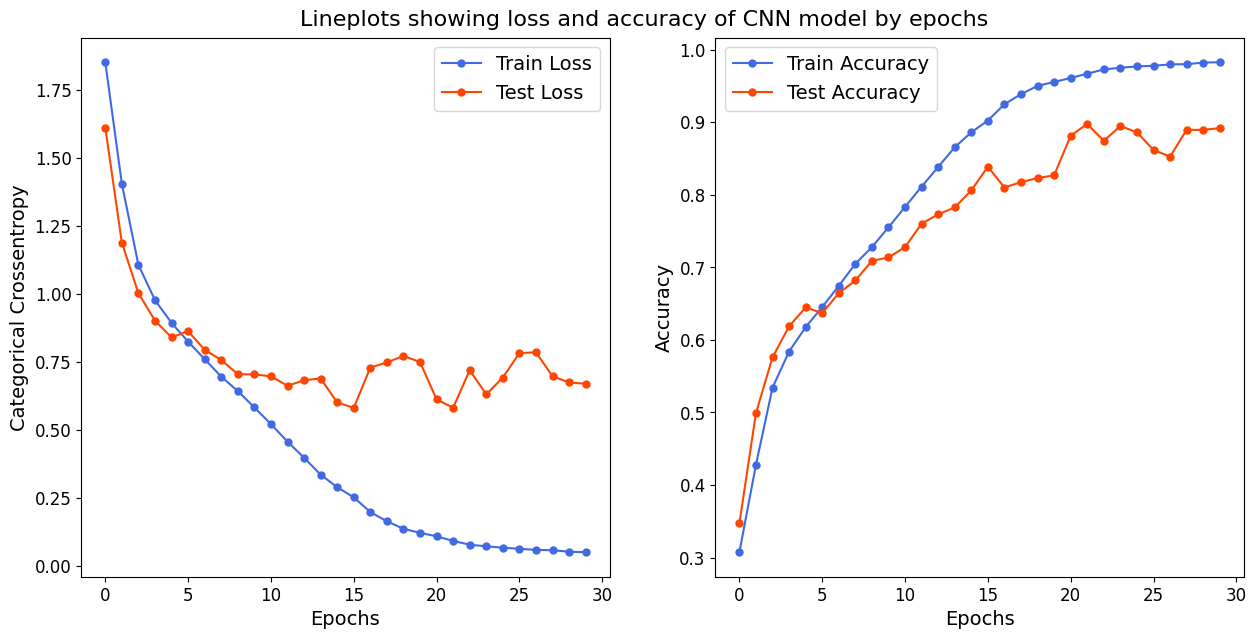

In [17]:
# Plotting a line chart to visualize the loss and accuracy values by epochs.

fig, ax = plt.subplots(ncols=2, figsize=(15,7))

ax = ax.ravel()

ax[0].plot(train_loss, label='Train Loss', color='royalblue', marker='o', markersize=5)
ax[0].plot(test_loss, label='Test Loss', color = 'orangered', marker='o', markersize=5)

ax[0].set_xlabel('Epochs', fontsize=14)
ax[0].set_ylabel('Categorical Crossentropy', fontsize=14)

ax[0].legend(fontsize=14)
ax[0].tick_params(axis='both', labelsize=12)

ax[1].plot(train_accuracy, label='Train Accuracy', color='royalblue', marker='o', markersize=5)
ax[1].plot(test_accuracy, label='Test Accuracy', color='orangered', marker='o', markersize=5)

ax[1].set_xlabel('Epochs', fontsize=14)
ax[1].set_ylabel('Accuracy', fontsize=14)

ax[1].legend(fontsize=14)
ax[1].tick_params(axis='both', labelsize=12)

fig.suptitle(x=0.5, y=0.92, t="Lineplots showing loss and accuracy of CNN model by epochs", fontsize=16)

# Exporting plot image in PNG format.
plt.savefig('/content/drive/My Drive/1_LiveProjects/Project5_AgeGenderEmotion_Detection/1.1_age_input_output/output/cnn_logs/final_vgg16_loss_accuracy.png', bbox_inches='tight');

In [18]:
# Evaluating the model on test dataset.

final_vgg16_score = vgg16_model.evaluate(test_dataset, verbose=1)

20/20 [==============================] - 3s 169ms/step - loss: 0.6704 - accuracy: 0.8918


In [19]:
# Printing the relevant score summary.

final_vgg16_labels = vgg16_model.metrics_names
print(f'CNN model {final_vgg16_labels[0]} \t\t= {round(final_vgg16_score[0], 3)}')
print(f'CNN model {final_vgg16_labels[1]} \t= {round(final_vgg16_score[1], 3)}')

CNN model loss 		= 0.67
CNN model accuracy 	= 0.892


In [20]:
# Saving the model as a h5 file for possible use later.

vgg16_model.save(f"/content/drive/My Drive/1_LiveProjects/Project5_AgeGenderEmotion_Detection/1.1_age_input_output/output/age_model_acc_{round(final_vgg16_score[1], 3)}.h5", save_format='h5')

In [21]:
# Generating predictions from the model above.

final_vgg16_pred = vgg16_model.predict(test_dataset)
final_vgg16_pred = final_vgg16_pred.argmax(axis=-1)

20/20 [==============================] - 3s 169ms/step


In [22]:
# Generating a confusion matrix based on above predictions.

conf_mat = confusion_matrix(test_labels_list, final_vgg16_pred)
conf_mat

array([[ 908,   43,    1,    0,    4,    2,    0],
       [  15,  806,   10,   10,    3,    1,    0],
       [   0,   23,  844,   44,   28,    2,    0],
       [   0,    3,   31, 1746,  211,   15,    1],
       [   1,    5,   27,  201, 2503,   60,   10],
       [   0,    2,    9,   31,  157, 1450,   30],
       [   1,    0,    2,    6,   23,   75,  702]])

In [23]:
# Defining a function to plot the confusion matrix in a grid for easier visualization.

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion Matrix', export_as='confusion_matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    # print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=16)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True labels', fontsize=14)
    plt.xlabel('Predicted labels', fontsize=14)

    # Exporting plot image in PNG format.
    plt.savefig(f'/content/drive/My Drive/1_LiveProjects/Project5_AgeGenderEmotion_Detection/1.1_age_input_output/output/cnn_logs/{export_as}.png', bbox_inches='tight');

Normalized confusion matrix


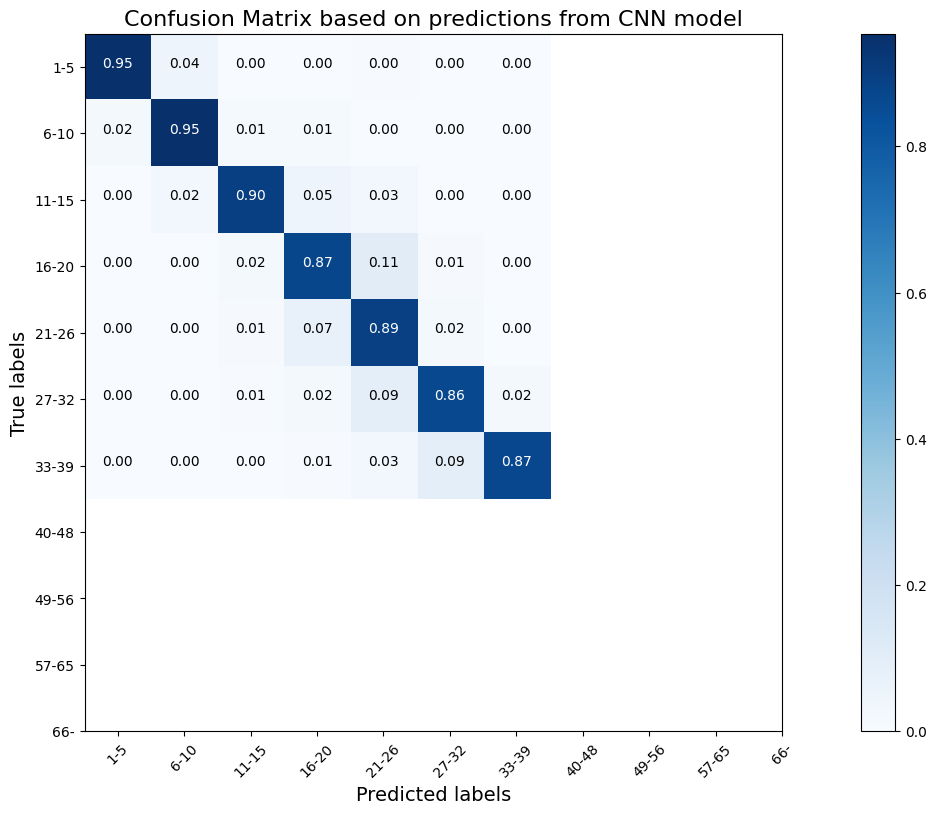

In [24]:
# Plotting the confusion matrix using the function defined above.

cm_plot_labels = ['1-5', '6-10', '11-15', '16-20', '21-26', '27-32', '33-39','40-48','49-56','57-65','66-']

plt.figure(figsize=(16,8))
plot_confusion_matrix(conf_mat, cm_plot_labels, normalize=True,
                      title="Confusion Matrix based on predictions from CNN model",
                      export_as="final_cnn_conf_mat_norm"
                     )

plt.show()